# Coupling Coefficient Analysis

In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
from matplotlib.colors import LogNorm
import warnings
import scipy.signal as sig
import scipy.stats as stats
import sys
import seaborn as sns
import matplotlib.colors as mcolors

sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import handy_roms_spec

import matplotlib as mpl
from dask.diagnostics import ProgressBar
warnings.filterwarnings("ignore")

In [5]:
from dask.diagnostics import ProgressBar
import dask
# dask.config.set(**{'array.slicing.split_large_chunks': True})
from dask.distributed import Client, LocalCluster

# cluster = LocalCluster(n_workers=61)
# client = Client(cluster)

# client

In [6]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder

In [7]:
import seawater as sw
def grid_dist_same(lon,lat):
    import seawater as sw
    if len(lon.shape)==2:
        grid_x=np.zeros(lon.shape)+np.nan
    else:
        grid_x=np.zeros([lat.shape[0],lon.shape[0]])
    
    grid_d=sw.dist(lon=lon,lat=lat)[0]
    grid_x[0:-1,:]=grid_d
    grid_x[-1,:]=grid_d[-1,:]
    
    return grid_x

def area_filter(lon,lat,filter_scale,dim_x,dim_y):
    #paramerers for convolution
    if dim_x=='x_rho' and dim_y=='y_rho':
    
        grid=grid_dist_same(lon,lat)
        gs=xr.DataArray(grid,dims=(dim_y,dim_x))

        radius = int( (filter_scale / gs.min().compute() / 2 ).round()) 
        # get the radius in grid-cells that covers the convolution kernel also for the smallest grid-spacing
        window_size = 2 * radius + 1


        gsr = gs.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")

        gsr_lat = gsr.cumsum("lat_window")
        gsr_lat -= gsr_lat.isel(lat_window=radius)
        gsr_lon = gsr.cumsum("lon_window")
        gsr_lon -= gsr_lon.isel(lon_window=radius)
        circ = ((gsr_lat ** 2 + gsr_lon ** 2) ** 0.5 < filter_scale / 2)
        Asum = (circ * (gsr ** 2)).sum(dim = ["lat_window","lon_window"])
    return gs,radius,circ,Asum

    
def apply_area_filter(var,gs,radius,circ,Asum):
    
    window_size = 2 * radius + 1
    
    var_sm = var.copy()
    var_sm += np.nan;



    varA  = gs ** 2 * var # multiplication with area
    varAr = varA.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")
    var_sm_tmp = ((varAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
    # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
    var_sm_tmp2 = np.zeros((var_sm_tmp.shape)) + np.nan
    var_sm_tmp2[radius:-radius,radius:-radius] = var_sm_tmp[radius:-radius,radius:-radius]
    var_sm[:] = var_sm_tmp2
    return var_sm


def apply_area_filter_t(var,gs,radius,circ,Asum):
    
    window_size = 2 * radius + 1
    
    var_sm = var.copy()
    var_sm += np.nan;



    varA  = gs ** 2 * var # multiplication with area
    varAr = varA.rolling(x_rho=window_size,center=True).construct("lon_window").rolling(y_rho=window_size, center=True).construct("lat_window")
    var_sm_tmp = ((varAr * circ).sum(dim = ["lat_window","lon_window"]) / Asum)
    # set the pixels at the boundary to NaN, where the convolution kernel extends over the boundary
    var_sm_tmp2 = np.zeros((var_sm_tmp.shape)) + np.nan
    var_sm_tmp2[:,radius:-radius,radius:-radius] = var_sm_tmp[:,radius:-radius,radius:-radius]
    var_sm[:] = var_sm_tmp2
    return var_sm
    



In [8]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

#### Reading CROCO files

In [9]:

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal')

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal')

#### Reading WRF files

In [10]:
chunks_new={'time_counter':40}

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'*DAY.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[-7:],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'*DAY.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[-7:],chunks=chunks_new)

#### Reading WRFout files

In [11]:

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listf_out=glob(path+'*out*');listf_out.sort()
varfout=xr.open_mfdataset(listf_out[-7:])

# path='/data/pacific/lrenault/SASI/SMTH/WRF/'
# listtw=glob(path+'*out*');listtw.sort()
# #vart=xr.open_dataset(listt[xmon])
# vartw=xr.open_mfdataset(listtw[-7:])

In [12]:
import pandas as pd
timer=pd.DatetimeIndex(varf.time_counter.groupby("time_counter.dayofyear").mean())[:-1]

In [13]:
dxx=0.5

### Interpolating WRF variables

In [ ]:
%%time
# chunks_new={'time_counter':40}

sst_w_f=regrid(varfw.SST,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

lh_f=regrid(varfw.LH,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
# lh_t=regrid(vartw.LH,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

sh_f=regrid(varfw.HFX,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]
# sh_t=regrid(vartw.HFX,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

swh_f=regrid(varfw.GSW,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1] #net shortwave
# swh_t=regrid(vartw.GSW,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1] 


glw_f=regrid(varfw.GLW,
                lons=varf.nav_lon_rho.data,
                lats=varf.nav_lat_rho.data,
                which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1] #downwelling long wave (needs to be subtract by S.Boltzman Law
# glw_t=regrid(vartw.GLW,
#                 lons=varf.nav_lon_rho.data,
#                 lats=varf.nav_lat_rho.data,
#                 which='grid')[0][:,100:-100,100:-200][:,1:-1,1:-1]

#### Long wave heat flux component Calculation

In [19]:
emss=1

# lwh_f=(5.67e-8*(tw_f)**4 - glw_f)
# lwh_t=(5.67e-8*(tw_t)**4 - glw_t)

# lwh_f=(5.67e-8*(tf.data+273.15)**4 - glw_f)
# lwh_t=(5.67e-8*(tt.data+273.15)**4 - glw_t)

lwh_f= (5.67e-8*(sst_w_f.data)**4)*emss -glw_f
# lwh_t=(5.67e-8*(tsk_t.data)**4 - glw_t)*emss

## Reading CROCO variables

In [20]:
%%time
chunks_new={'dayofyear':40}

tf=varf.temp.groupby("time_counter.dayofyear").mean('time_counter')
tf=tf.chunk(chunks=chunks_new);
tf=tf[:,100:-100,100:-200].compute();
tf=tf[:-1,1:-1,1:-1]


# tt=vart.temp.groupby("time_counter.dayofyear").mean()
# tt=tt.chunk(chunks=chunks_new);
# tt=tt[:,100:-100,100:-200].compute()
# tt=tt[:-1,1:-1,1:-1]


hf=-varf.shflx.groupby("time_counter.dayofyear").mean()
hf=hf.chunk(chunks=chunks_new);
hf=hf[:,100:-100,100:-200].compute();
hf=hf[:-1,1:-1,1:-1]


# ht=-vart.shflx.groupby("time_counter.dayofyear").mean()
# ht=ht.chunk(chunks=chunks_new);
# ht=ht[:,100:-100,100:-200].compute();
# ht=ht[:-1,1:-1,1:-1]

CPU times: user 24.5 s, sys: 35.8 s, total: 1min
Wall time: 10.1 s


In [22]:
sh_f=sh_f.rename({'x': 'x_rho','y': 'y_rho'})

lh_f=lh_f.rename({'x': 'x_rho','y': 'y_rho'})

lwh_f=lwh_f.rename({'x': 'x_rho','y': 'y_rho'})

swh_f=swh_f.rename({'x': 'x_rho','y': 'y_rho'})

### Net heatflux from WRF

In [42]:

# day=10
# hwf= swh_f[day].data -sh_f[day].data - lh_f[day].data -lwh_f[day].data

# plt.figure()

# plt.plot(-hf[day,500,:])
# plt.plot(hwf[500,:])

# plt.contourf(hf.nav_lon_rho,hf.nav_lat_rho,-hf[day])
# plt.figure()
# plt.contourf(hf.nav_lon_rho,hf.nav_lat_rho,hwf)

# Filtering at 50km range

In [16]:
%%time
grid_croco,scale_radius,scale_circ,scale_areasum=area_filter(lon=tf.nav_lon_rho,
                              lat=tf.nav_lat_rho,
                              filter_scale=50,dim_x='x_rho',dim_y='y_rho')

CPU times: user 3min 22s, sys: 4min 46s, total: 8min 9s
Wall time: 8min 9s


In [267]:
%%time
day_i=0


tf_sm=apply_area_filter(tf[day_i],gs=grid_croco,
                        radius=scale_radius,circ=scale_circ,Asum=scale_areasum)


hf_sm=apply_area_filter(hf[day_i],gs=grid_croco,
                        radius=scale_radius,circ=scale_circ,Asum=scale_areasum)



CPU times: user 51.9 s, sys: 1min 17s, total: 2min 9s
Wall time: 2min 9s


In [273]:
# r_tf_sm=tf_sm.data.ravel()[~np.isnan(tf_sm.data.ravel())]
# r_hf_sm=hf_sm.data.ravel()[~np.isnan(hf_sm.data.ravel())]
r_tf_sm=tf_sm.data[~np.isnan(tf_sm.data)]
r_hf_sm=hf_sm.data[~np.isnan(hf_sm.data)]

# r_tf_f=(tf[day_i]-tf_sm).data.ravel()[~np.isnan(tf_sm.data.ravel())]
# r_hf_f=(hf[day_i]-hf_sm).data.ravel()[~np.isnan(tf_sm.data.ravel())]
r_tf_f=(tf[day_i]-tf_sm).data[~np.isnan(tf_sm.data)]
r_hf_f=(hf[day_i]-hf_sm).data[~np.isnan(tf_sm.data)]

In [275]:
af_sm,bf_sm=np.polyfit(r_tf_sm,r_hf_sm,deg=1)
af_f,bf_f=np.polyfit(r_tf_f,r_hf_f,deg=1)

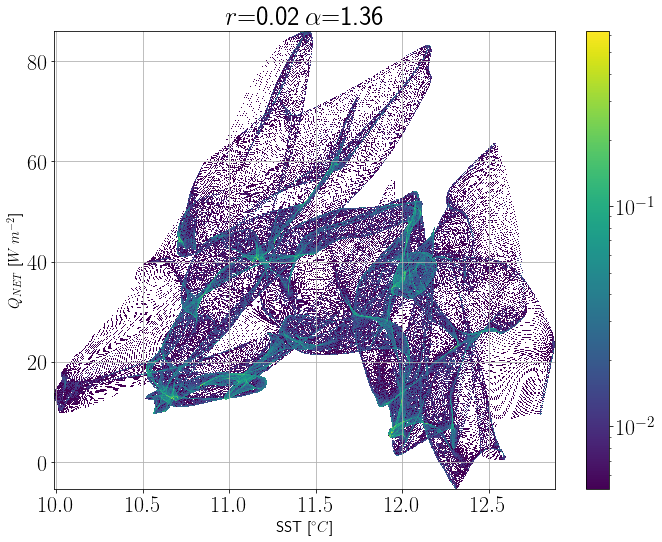

In [276]:


plt.figure(figsize=(10,8))
plt.hist2d(r_tf_sm,r_hf_sm,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_sm,r_hf_sm)[0][1])+ r'$\,\alpha$={0:.2f}'.format(af_sm))



plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_scatter_t_bar_hfx_bar.png'.format(day_i))

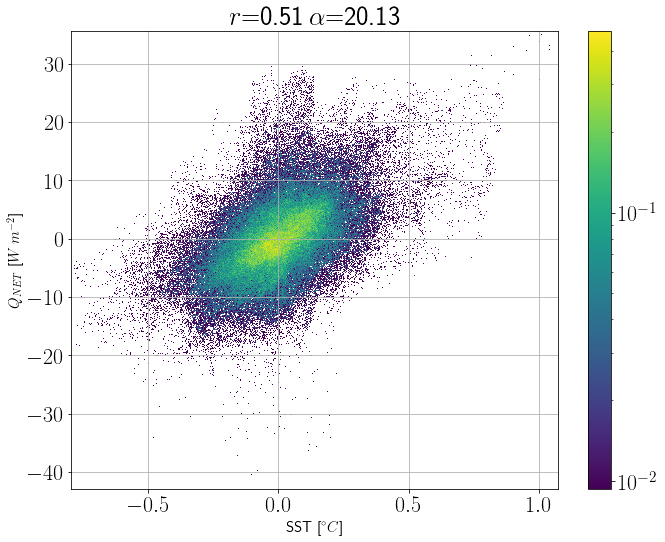

In [277]:
plt.figure(figsize=(10,8))
plt.hist2d(r_tf_f,r_hf_f,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,r_hf_f)[0][1])+ r'$\,\alpha$={0:.2f}'.format(af_f))



plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_scatter_t_prime_hfx_prime.png'.format(day_i))

In [278]:
%%time


sh_f_sm=apply_area_filter(sh_f[day_i],gs=grid_croco,
                        radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

lh_f_sm=apply_area_filter(lh_f[day_i],gs=grid_croco,
                        radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

sw_f_sm=apply_area_filter(swh_f[day_i],gs=grid_croco,
                        radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

lw_f_sm=apply_area_filter(lwh_f[day_i],gs=grid_croco,
                        radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

CPU times: user 2min 29s, sys: 2min 38s, total: 5min 8s
Wall time: 5min 7s


In [279]:
r_sh_f_sm=sh_f_sm.to_numpy()[~np.isnan(sh_f_sm.to_numpy())]
r_lh_f_sm=lh_f_sm.to_numpy()[~np.isnan(lh_f_sm.to_numpy())]
r_sw_f_sm=sw_f_sm.to_numpy()[~np.isnan(sw_f_sm.to_numpy())]
r_lw_f_sm=lw_f_sm.to_numpy()[~np.isnan(lw_f_sm.to_numpy())]



r_sh_f_f=(sh_f[day_i]-sh_f_sm).to_numpy()[~np.isnan(sh_f_sm.to_numpy())]
r_lh_f_f=(lh_f[day_i]-lh_f_sm).to_numpy()[~np.isnan(lh_f_sm.to_numpy())]
r_sw_f_f=(swh_f[day_i]-sw_f_sm).to_numpy()[~np.isnan(sw_f_sm.to_numpy())]
r_lw_f_f=(lwh_f[day_i]-lw_f_sm).to_numpy()[~np.isnan(lw_f_sm.to_numpy())]




In [280]:
a_r_f,b_r_f=np.polyfit(r_tf_f,(r_sh_f_f+r_lh_f_f),deg=1)
a_r_sm,b_r_sm=np.polyfit(r_tf_sm,(r_sh_f_sm+r_lh_f_sm),deg=1)

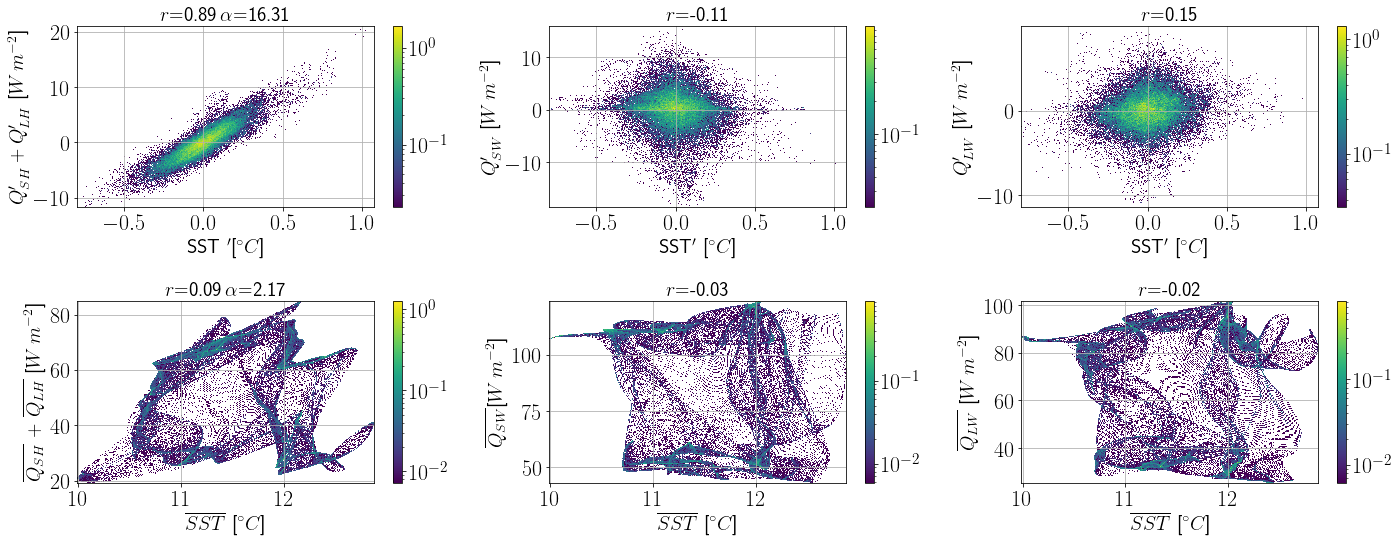

In [281]:
plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plt.hist2d(r_tf_f,(r_sh_f_f+r_lh_f_f),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST $^{\prime}$[$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{SH}^{\prime} + Q_{LH}^{\prime}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,(r_sh_f_f+r_lh_f_f))[0][1])+ r'$\,\alpha$={0:.2f}'.format(a_r_f),fontsize=20)
plt.colorbar()



plt.subplot(2,3,2)
plt.hist2d(r_tf_f,r_sw_f_f,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q^{\prime}_{SW}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,r_sw_f_f)[0][1]),fontsize=20)
plt.colorbar()



plt.subplot(2,3,3)
plt.hist2d(r_tf_f,r_lw_f_f,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{LW}^{\prime}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,r_lw_f_f)[0][1]),fontsize=20)
plt.colorbar()




plt.subplot(2,3,4)
plt.hist2d(r_tf_sm,(r_sh_f_sm+r_lh_f_sm),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$\overline{Q_{SH}}$ + $\overline{Q_{LH}}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,(r_sh_f_sm+r_lh_f_sm))[0][1])+ r'$\,\alpha$={0:.2f}'.format(a_r_sm),fontsize=20)
plt.colorbar()



plt.subplot(2,3,5)
plt.hist2d(r_tf_sm,r_sw_f_sm,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$\overline{Q_{SW}}$[$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,r_sw_f_sm)[0][1]),fontsize=20)
plt.colorbar()



plt.subplot(2,3,6)
plt.hist2d(r_tf_sm,r_lw_f_sm,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$\overline{Q_{LW}}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_tf_f,r_lw_f_sm)[0][1]),fontsize=20)
plt.colorbar()


plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_scatter_all_TxQ.png'.format(day_i))

In [282]:
a_r_tot,b_r_tot=np.polyfit((r_tf_f+r_tf_sm),(r_sh_f_sm+r_lh_f_sm+r_sh_f_f+r_lh_f_f),deg=1)

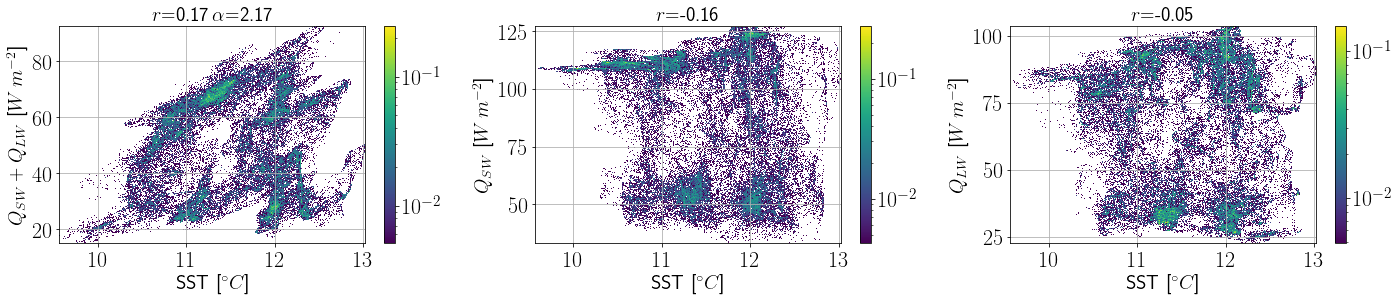

In [283]:
plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plt.hist2d((r_tf_f+r_tf_sm),(r_sh_f_sm+r_lh_f_sm+r_sh_f_f+r_lh_f_f),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{SW}+ Q_{LW}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef((r_tf_f+r_tf_sm),
                                               (r_sh_f_sm+r_lh_f_sm+r_sh_f_f+r_lh_f_f))[0][1])+ r'$\,\alpha$={0:.2f}'.format(a_r_tot),fontsize=20)
plt.colorbar()


plt.subplot(2,3,2)
plt.hist2d((r_tf_f+r_tf_sm),(r_sw_f_f+r_sw_f_sm),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{SW}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef((r_tf_f+r_tf_sm),(r_sw_f_f+r_sw_f_sm))[0][1]),fontsize=20)
plt.colorbar()



plt.subplot(2,3,3)
plt.hist2d((r_tf_f+r_tf_sm),(r_lw_f_f+r_lw_f_sm),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{LW}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef((r_tf_f+r_tf_sm),(r_lw_f_f+r_lw_f_sm))[0][1]),fontsize=20)
plt.colorbar()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_original_scatter_all_TxQ.png'.format(day_i))

## Same Analysis, more days for sample

In [77]:
%%time
Tf_sm=np.zeros(tf[::20,:,:].shape)+np.nan;
Hf_sm=np.zeros(hf[::20,:,:].shape)+np.nan;


for ix in range(Tf_sm.shape[0]):
    Tf_sm[ix,:,:]=apply_area_filter(tf[ix],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)


    Hf_sm[ix,:,:]=apply_area_filter(hf[ix],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

CPU times: user 9min 28s, sys: 14min 12s, total: 23min 40s
Wall time: 23min 40s


In [80]:
Tf_sm.shape

(11, 1318, 698)

In [81]:
r_Tf_sm=Tf_sm[~np.isnan(Tf_sm.data)]
r_Hf_sm=Hf_sm[~np.isnan(Hf_sm.data)]

In [82]:
r_Tf_f=(tf[::20].data-Tf_sm)[~np.isnan(Tf_sm)]
r_Hf_f=(hf[::20].data-Hf_sm)[~np.isnan(Tf_sm)]

In [235]:
a_T_f,b_T_f=np.polyfit(r_Tf_f,r_Hf_f,deg=1)
a_T_sm,b_T_sm=np.polyfit(r_Tf_sm,r_Hf_sm,deg=1)

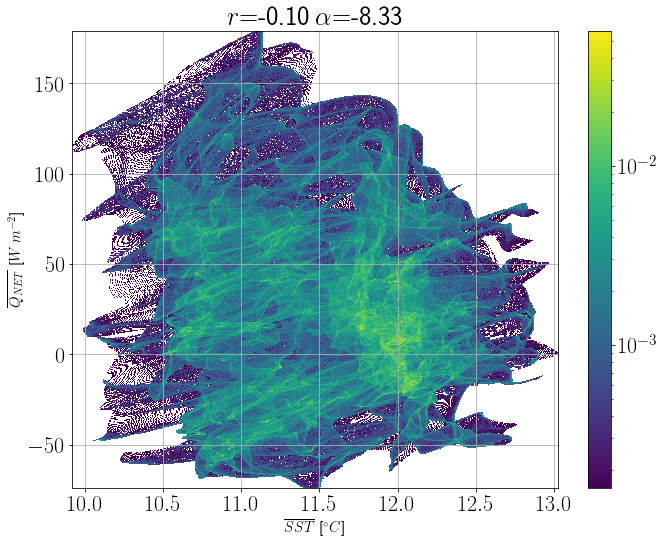

In [265]:


plt.figure(figsize=(10,8))
plt.hist2d(r_Tf_sm,r_Hf_sm,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$\overline{Q_{NET}}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_sm,r_Hf_sm)[0][1])+ r'$\,\alpha$={0:.2f}'.format(a_T_sm))



plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/TIME_scatter_t_bar_hfx_bar.png')

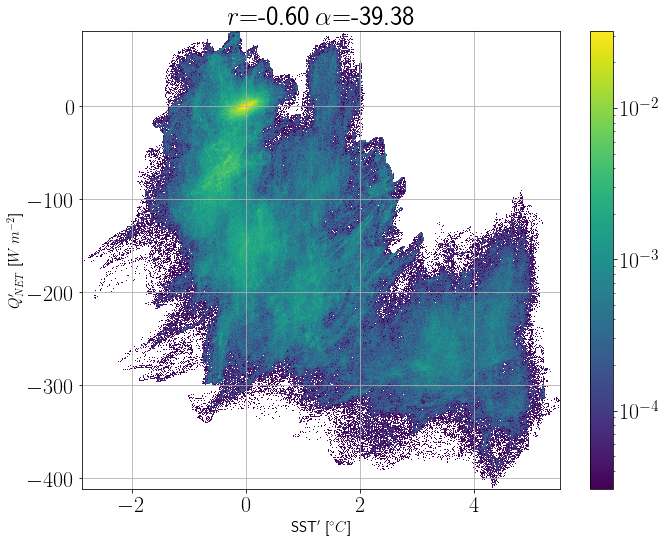

In [266]:
plt.figure(figsize=(10,8))
plt.hist2d(r_Tf_f,r_Hf_f,bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}C$]',fontsize=15,fontweight='bold')
plt.ylabel(r'$Q_{NET}^{\prime}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_f,r_Hf_f)[0][1])+ r'$\,\alpha$={0:.2f}'.format(a_T_f))



plt.colorbar()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/TIME_scatter_t_prime_hfx_prime.png')

In [101]:
# for izz in range(Tf_sm.shape[0]):
#     plt.figure()
#     plt.hist2d((tf[::20][izz].data-Tf_sm[izz])[~np.isnan(Tf_sm[izz].data)],
#                (hf[::20][izz].data-Hf_sm[izz])[~np.isnan(Hf_sm[izz].data)],bins=1000,density=True,norm=mpl.colors.LogNorm())
#     plt.grid()
#     plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
#     plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
#     plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef((tf[::20][izz].data-Tf_sm[izz])[~np.isnan(Tf_sm[izz].data)],
#                (hf[::20][izz].data-Hf_sm[izz])[~np.isnan(Hf_sm[izz].data)])[0][1]))




In [103]:
%%time
QH_sm=np.zeros(lh_f[::20,:,:].shape)+np.nan;
SW_sm=np.zeros(swh_f[::20,:,:].shape)+np.nan;
LW_sm=np.zeros(lwh_f[::20,:,:].shape)+np.nan;



for iw in range(QH_sm.shape[0]):
    QH_sm[iw,:,:]=apply_area_filter((sh_f+lh_f)[iw],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

    SW_sm[iw,:,:]=apply_area_filter(swh_f[iw],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

    LW_sm[iw,:,:]=apply_area_filter(lwh_f[iw],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

CPU times: user 21min 15s, sys: 22min 14s, total: 43min 29s
Wall time: 43min 3s


In [125]:
r_QH_sm=QH_sm[~np.isnan(QH_sm)]
r_SW_sm=SW_sm[~np.isnan(SW_sm)]
r_LW_sm=LW_sm[~np.isnan(LW_sm)]





r_QH_f=(sh_f[::20]+ lh_f[::20] - QH_sm).to_numpy()[~np.isnan(QH_sm)]
r_SW_f=(swh_f[::20] - SW_sm).to_numpy()[~np.isnan(SW_sm)]
r_LW_f=(lwh_f[::20] - LW_sm).to_numpy()[~np.isnan(LW_sm)]


# r_SW_f=(swh_f[day_i]-sw_f_sm).to_numpy()[~np.isnan(sw_f_sm.to_numpy())]
# r_LW_f=(lwh_f[day_i]-lw_f_sm).to_numpy()[~np.isnan(lw_f_sm.to_numpy())]





In [240]:
a_Q_f,b_Q_f=np.polyfit(r_Tf_f,r_QH_f,deg=1)
a_Q_sm,b_Q_sm=np.polyfit(r_Tf_sm,r_QH_sm,deg=1)

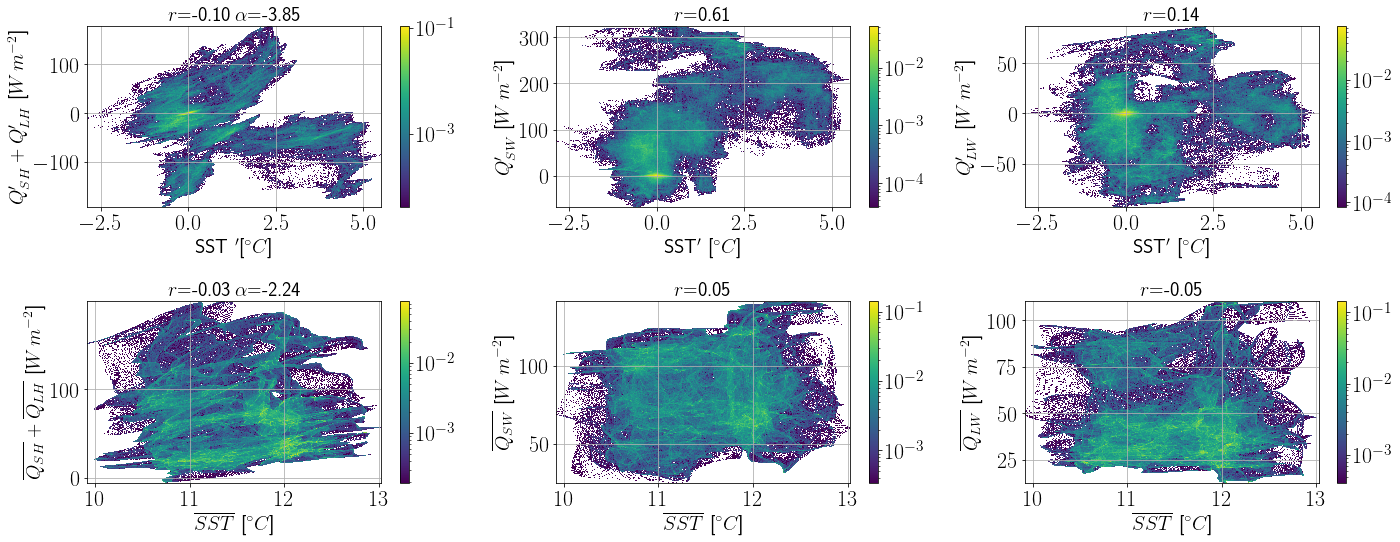

In [284]:
plt.figure(figsize=(20,8))
plt.subplot(2,3,1)
plt.hist2d(r_Tf_f,(r_QH_f),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()
plt.xlabel(r'SST $^{\prime}$[$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{SH}^{\prime} + Q_{LH}^{\prime}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_f,r_QH_f)[0][1]) + r'$\,\alpha$={0:.2f}'.format(a_Q_f),fontsize=20)
plt.colorbar()



plt.subplot(2,3,2)
plt.hist2d(r_Tf_f,(r_SW_f),bins=1000,density=True,norm=mpl.colors.LogNorm())

plt.grid()
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q^{\prime}_{SW}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_f,r_SW_f)[0][1]),fontsize=20)
plt.colorbar()



plt.subplot(2,3,3)
plt.hist2d(r_Tf_f,(r_LW_f),bins=1000,density=True,norm=mpl.colors.LogNorm())

plt.grid()
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{LW}^{\prime}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_f,r_LW_f)[0][1]),fontsize=20)
plt.colorbar()



plt.subplot(2,3,4)
plt.hist2d(r_Tf_sm,(r_QH_sm),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.grid()

plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$\overline{Q_{SH}} + \overline{Q_{LH}}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_sm,r_QH_sm)[0][1])+ r'$\,\alpha$={0:.2f}'.format(a_Q_sm),fontsize=20)
plt.colorbar()



plt.subplot(2,3,5)
plt.hist2d(r_Tf_sm,(r_SW_sm),bins=1000,density=True,norm=mpl.colors.LogNorm())

plt.grid()

plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$\overline{Q_{SW}}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_sm,r_SW_sm)[0][1]),fontsize=20)
plt.colorbar()



plt.subplot(2,3,6)
plt.hist2d(r_Tf_sm,(r_LW_sm),bins=1000,density=True,norm=mpl.colors.LogNorm())

plt.grid()
plt.xlabel(r'$\overline{SST}$ [$^{\circ}C$]',fontsize=20,fontweight='bold')
plt.ylabel(r'$\overline{Q_{LW}}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(r_Tf_sm,r_LW_sm)[0][1]),fontsize=20)
plt.colorbar()

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/TIME_scatter_all_TxQ.png')

In [19]:
# for izz in range(Tf_sm.shape[0]):
#     plt.figure()
#     plt.hist2d((tf[::20][izz].data-Tf_sm[izz])[~np.isnan(Tf_sm[izz].data)],
#                ((sh_f+lh_f)[::20][izz].data-QH_sm[izz]).compute()[~np.isnan(QH_sm[izz])],
#                bins=1000,density=True,norm=mpl.colors.LogNorm())
#     plt.grid()
#     plt.xlabel(r'SST [$^{\circ}C$]',fontsize=15,fontweight='bold')
#     plt.ylabel(r'$Q_{NET}$ [$W\,m^{-2}$]',fontsize=15,fontweight='bold')
#     plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef((tf[::20][izz].data-Tf_sm[izz])[~np.isnan(Tf_sm[izz].data)],
#                ((sh_f+lh_f)[::20][izz].data-QH_sm[izz]).compute()[~np.isnan(QH_sm[izz])])[0][1]))




# $\alpha (t)$

In [45]:
qf=sh_f.compute()+lh_f.compute()

In [77]:
%%time
dec=2
tdec=3


tf_sm=tf[::tdec,::dec,::dec].copy()
qf_sm=qf[::tdec,::dec,::dec].copy()
scal_i=65



grid_croco,scale_radius,scale_circ,scale_areasum=area_filter(lon=tf[0,::dec,::dec].nav_lon_rho,
                              lat=tf[0,::dec,::dec].nav_lat_rho,
                              filter_scale=scal_i,dim_x='x_rho',dim_y='y_rho')

CPU times: user 21.4 s, sys: 27.1 s, total: 48.5 s
Wall time: 48.5 s


In [78]:
%%time

counter=0
for tms in (tf.dayofyear-1).data[::tdec]:    
    tf_sm[counter,:,:]=apply_area_filter(tf[tms,::dec,::dec],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

    qf_sm[counter,:,:]=apply_area_filter(qf[tms,::dec,::dec],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)
    counter+=1

CPU times: user 6min 26s, sys: 9min 33s, total: 16min
Wall time: 16min


In [79]:
rtf_f=(tf[::tdec,::dec,::dec]-tf_sm).data[:,~np.isnan(tf_sm[0].data)]
rqf_f=(qf[::tdec,::dec,::dec]-qf_sm).data[:,~np.isnan(tf_sm[0].data)]

In [80]:
b_t_filtered.mean()

0.003637325220677816

In [81]:
alpha_t_filtered.mean()

28.00208951701264

In [82]:
alpha_t_filtered= np.array([np.polyfit(rtf_f[dayss],rqf_f[dayss],deg=1)[0] for dayss in np.arange(rtf_f.shape[0])])
b_t_filtered= np.array([np.polyfit(rtf_f[dayss],rqf_f[dayss],deg=1)[1] for dayss in np.arange(rtf_f.shape[0])])


pearsonr_t_filtered= np.array([np.corrcoef(rtf_f[dayss],rqf_f[dayss])[0][1] for dayss in np.arange(rtf_f.shape[0])])

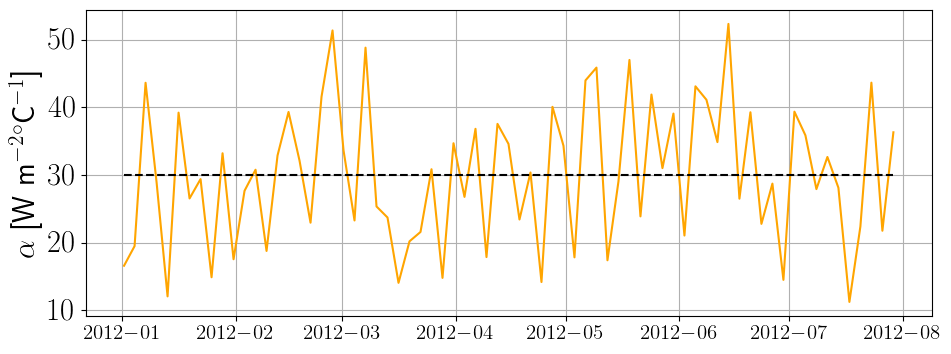

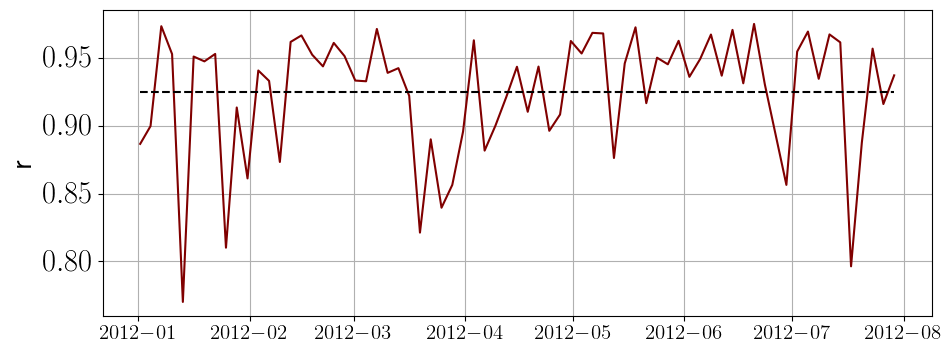

In [83]:
plt.figure(figsize=(10,4))
# plt.plot(tf.dayofyear,np.corrcoef())
plt.plot(timer[::tdec],alpha_t_filtered,color='orange')
plt.plot(timer[::tdec],np.zeros(alpha_t_filtered.shape)+np.nanmean(alpha_t_filtered),'--',color='black')
# plt.xlabel('Days')
plt.ylabel(r'$\alpha$ [W m$^{-2}$$^{\circ}$C$^{-1}$]')
plt.xticks(fontsize=15)
plt.tight_layout()
plt.grid()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/alpha(t)_(SH+LH)_scale{0}km.png'.format(scal_i))

plt.figure(figsize=(10,4))
# plt.plot(tf.dayofyear,np.corrcoef())
plt.plot(timer[::tdec],pearsonr_t_filtered,color='maroon')
plt.plot(timer[::tdec],np.zeros(pearsonr_t_filtered.shape)+np.nanmean(pearsonr_t_filtered),'--',color='black')
# plt.xlabel('Days')
plt.ylabel(r'r')
plt.xticks(fontsize=15)
plt.tight_layout()
plt.grid()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/pearson_r(t)_(SH+LH)_scale{0}km.png'.format(scal_i))

In [84]:
np.corrcoef(np.ravel(rtf_f),np.ravel(rqf_f))[0][1]

0.9004365566047019

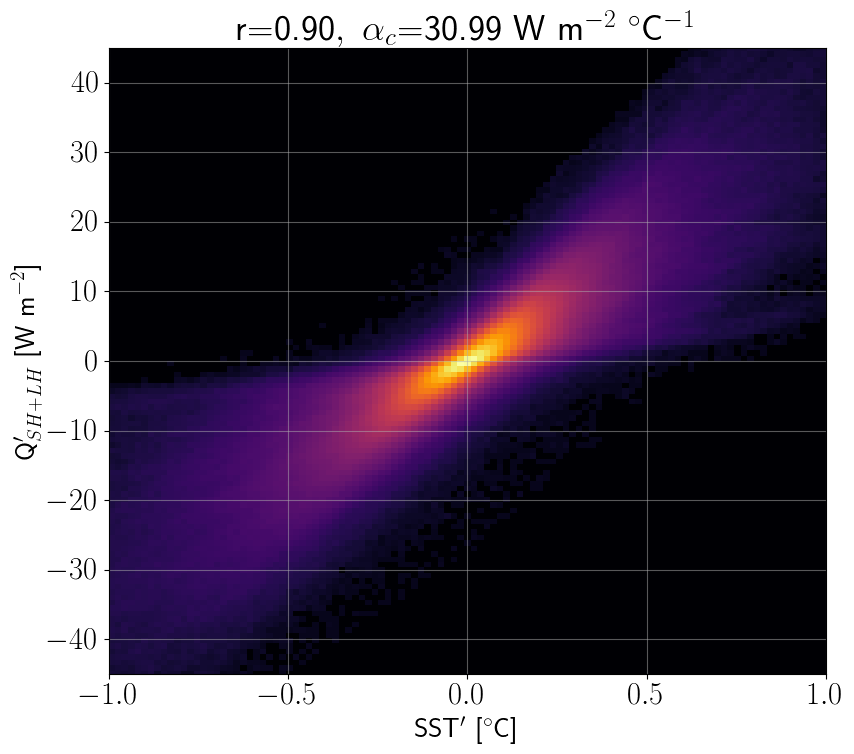

In [92]:
plt.figure(figsize=(9,8))
# plt.hist2d(np.ravel(rtf_f),np.ravel(rqf_f),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.hist2d(np.ravel(rtf_f),np.ravel(rqf_f),bins=200,density=True,norm=mcolors.PowerNorm(0.25),cmap='inferno')
# plt.colorbar()

plt.grid(alpha=0.5)
plt.xlabel(r'SST$^{\prime}$ [$^{\circ}$C]',fontsize=20,fontweight='bold')
plt.ylabel(r'Q$_{SH + LH}^{\prime}$ [W m$^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'r'+'={0:.2f}'.format(np.corrcoef(np.ravel(rtf_f),np.ravel(rqf_f))[0][1])+ r'$,\,\,\alpha_c$={0:.2f}'.format(np.polyfit(np.ravel(rtf_f),np.ravel(rqf_f),deg=1)[0]) 
          +r' W m$^{-2}$ $^{\circ}$C$^{-1}$')
# plt.colorbar()
plt.xlim(-1,1)
plt.ylim(-45,45)
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/total_scatter_SSTx(LH+SH)_{0}km.png'.format(scal_i))


# $\alpha \times \lambda$

### Fixed day

In [93]:
# %%time
# scales_number=[10,30,50,70,90,100]    
# day_i=48

# alpha_f_scal=[]
# pearsonr_f_scal=[]
# alpha_sm_scal=[]
# pearsonr_sm_scal=[]
# dec=2
# for scal in scales_number:    
    
#     grid_croco,scale_radius,scale_circ,scale_areasum=area_filter(lon=tf[:,::dec,::dec].nav_lon_rho,
#                                   lat=tf[:,::dec,::dec].nav_lat_rho,
#                                   filter_scale=scal,dim_x='x_rho',dim_y='y_rho')


#     tf_sm=apply_area_filter(tf[day_i][::dec,::dec],gs=grid_croco,
#                             radius=scale_radius,circ=scale_circ,Asum=scale_areasum)


#     qf_sm=apply_area_filter(qf[day_i][::dec,::dec],gs=grid_croco,
#                             radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

#     r_tf_sm=tf_sm.data[~np.isnan(tf_sm.data)]
#     r_qf_sm=qf_sm.data[~np.isnan(qf_sm.data)]


#     r_tf_f=(tf[day_i][::dec,::dec]-tf_sm).data[~np.isnan(tf_sm.data)]
#     r_qf_f=(qf[day_i][::dec,::dec]-qf_sm).data[~np.isnan(qf_sm.data)]
    
#     alpha_f_scal.append(np.polyfit(r_tf_f,r_qf_f,deg=1)[0])
#     pearsonr_f_scal.append(np.corrcoef(r_tf_f,r_qf_f)[0][1])
#     alpha_sm_scal.append(np.polyfit(r_tf_sm,r_qf_sm,deg=1))
#     pearsonr_sm_scal.append(np.corrcoef(r_tf_sm,r_qf_sm)[0][1])





CPU times: user 2min 42s, sys: 3min 35s, total: 6min 17s
Wall time: 6min 17s


### Multiple days

In [109]:
%%time
scales_number=[10,30,50,70,90,100]    
dayray=np.arange(1,4,1)

alpha_f_scal=[]
pearsonr_f_scal=[]
alpha_sm_scal=[]
pearsonr_sm_scal=[]

tf_sm=tf[dayray,::dec,::dec].copy()
qf_sm=qf[dayray,::dec,::dec].copy()


dec=2
for scal in scales_number:    
    
    grid_croco,scale_radius,scale_circ,scale_areasum=area_filter(lon=tf[0,::dec,::dec].nav_lon_rho,
                                  lat=tf[0,::dec,::dec].nav_lat_rho,
                                  filter_scale=scal,dim_x='x_rho',dim_y='y_rho')

    
    counter=0
    for tms in dayray:    
        tf_sm[counter,:,:]=apply_area_filter(tf[tms][::dec,::dec],gs=grid_croco,
                                radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

        qf_sm[counter,:,:]=apply_area_filter(qf[tms][::dec,::dec],gs=grid_croco,
                                radius=scale_radius,circ=scale_circ,Asum=scale_areasum)
        counter+=1

    r_tf_sm=tf_sm.data[~np.isnan(tf_sm.data)]
    r_qf_sm=qf_sm.data[~np.isnan(qf_sm.data)]


    r_tf_f=(tf[dayray,::dec,::dec]-tf_sm).data[~np.isnan(tf_sm.data)]
    r_qf_f=(qf[dayray,::dec,::dec]-qf_sm).data[~np.isnan(qf_sm.data)]

    alpha_f_scal.append(np.polyfit(r_tf_f,r_qf_f,deg=1)[0])
    pearsonr_f_scal.append(np.corrcoef(r_tf_f,r_qf_f)[0][1])
    alpha_sm_scal.append(np.polyfit(r_tf_sm,r_qf_sm,deg=1))
    pearsonr_sm_scal.append(np.corrcoef(r_tf_sm,r_qf_sm)[0][1])



CPU times: user 3min 54s, sys: 5min 6s, total: 9min
Wall time: 8min 46s


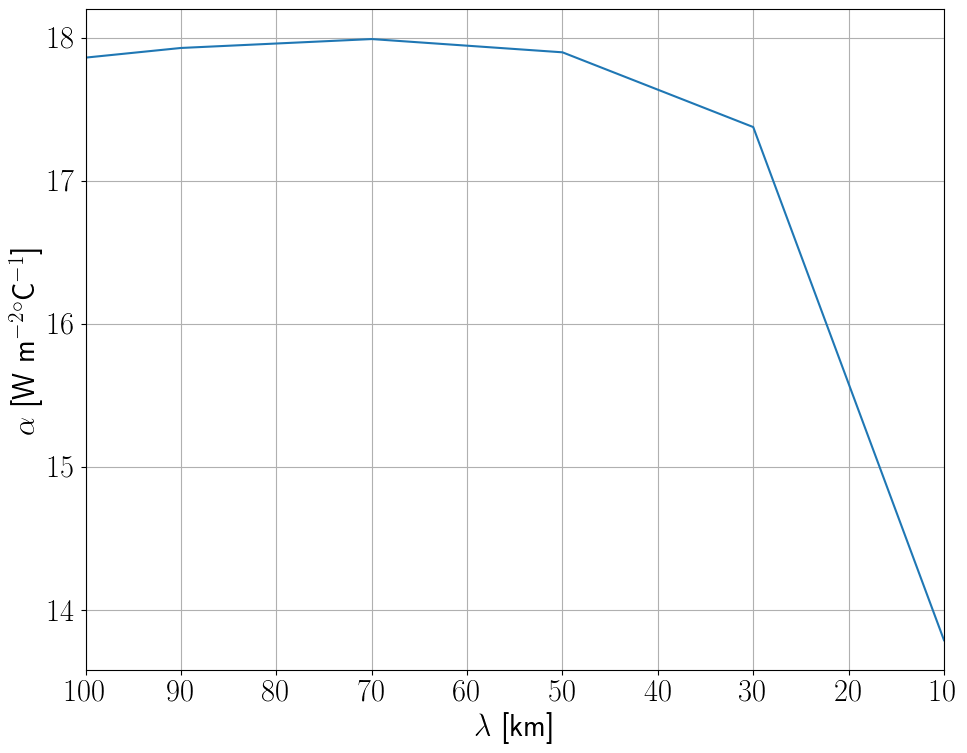

In [111]:
plt.figure(figsize=(10,8))
plt.plot(np.array(scales_number),alpha_f_scal)
plt.ylabel(r'$\alpha$ [W m$^{-2}$$^{\circ}$C$^{-1}$]')
plt.xlabel(r'$\lambda$ [km]')
plt.xlim(np.array(scales_number).max(),np.array(scales_number).min())
plt.grid()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_alpha_x_lamdba_day.png'.format(dayray))

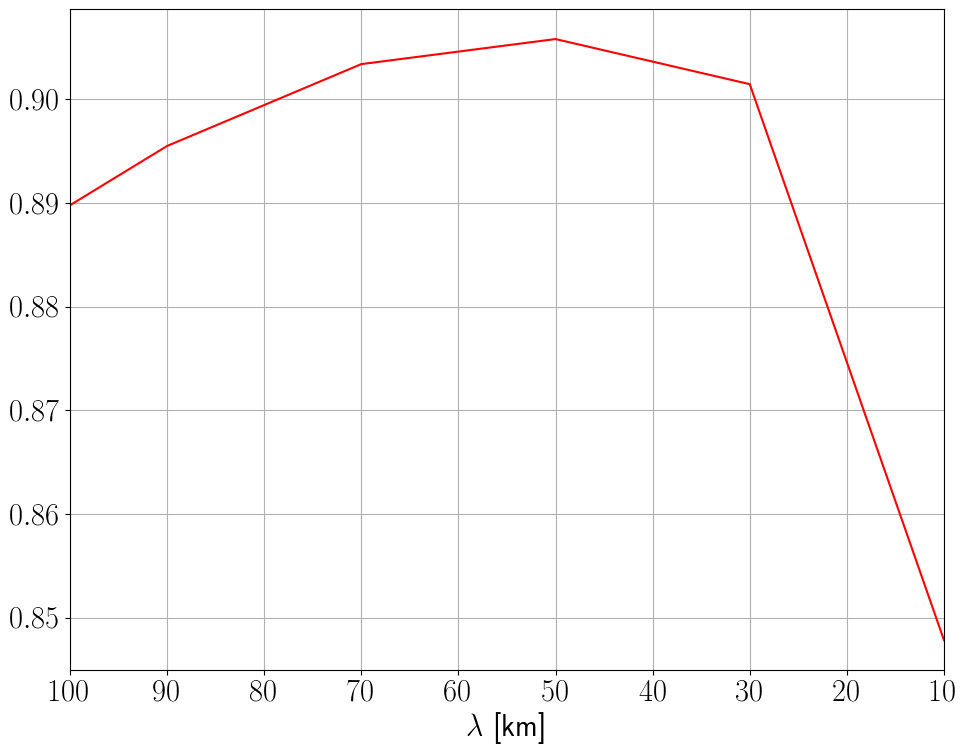

In [112]:
plt.figure(figsize=(10,8))
plt.plot(np.array(scales_number),pearsonr_f_scal,color='red')
# plt.ylabel(r'$\alpha$ [W m$^{-2}$$^{\circ}$C$^{-1}$]')
plt.xlabel(r'$\lambda$ [km]')
plt.xlim(np.array(scales_number).max(),np.array(scales_number).min())
plt.grid()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_correlation_x_lamdba_day.png'.format(day_i))

# $\alpha_{S}$

In [121]:
sf=varf.salt.groupby("time_counter.dayofyear").mean('time_counter')
sf=sf.chunk(chunks=chunks_new);
sf=sf[:,100:-100,100:-200].compute();
sf=sf[:-1,1:-1,1:-1]

In [126]:

dec=2
tdec=3


sf_sm=sf[::tdec,::dec,::dec].copy()
qf_sm=sf[::tdec,::dec,::dec].copy()


scal_i=30



grid_croco,scale_radius,scale_circ,scale_areasum=area_filter(lon=sf[0,::dec,::dec].nav_lon_rho,
                              lat=sf[0,::dec,::dec].nav_lat_rho,
                              filter_scale=scal_i,dim_x='x_rho',dim_y='y_rho')

In [127]:
%%time

counter=0
for tms in (sf.dayofyear-1).data[::tdec]:    
    sf_sm[counter,:,:]=apply_area_filter(sf[tms,::dec,::dec],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

    qf_sm[counter,:,:]=apply_area_filter(qf[tms,::dec,::dec],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)
    counter+=1

CPU times: user 1min 39s, sys: 2min 2s, total: 3min 42s
Wall time: 3min 42s


In [165]:
rsf_f=(sf[::tdec,::dec,::dec]-sf_sm).data[:,~np.isnan(sf_sm[0].data)]
rqf_f=(qf[::tdec,::dec,::dec]-qf_sm.data).data[:,~np.isnan(qf_sm[0].data)]

In [166]:
alphaS_t_filtered= np.array([np.polyfit(rsf_f[dayss],rqf_f[dayss],deg=1)[0] for dayss in np.arange(rsf_f.shape[0])])

pearsonr_t_filtered= np.array([np.corrcoef(rsf_f[dayss],rqf_f[dayss])[0][1] for dayss in np.arange(rsf_f.shape[0])])

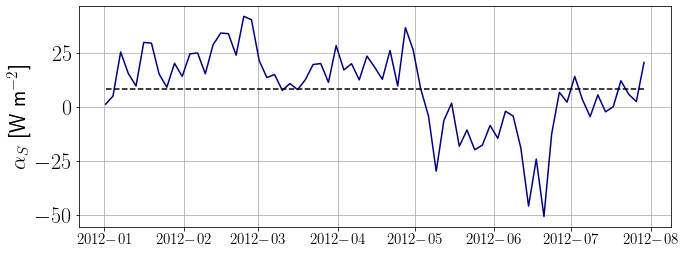

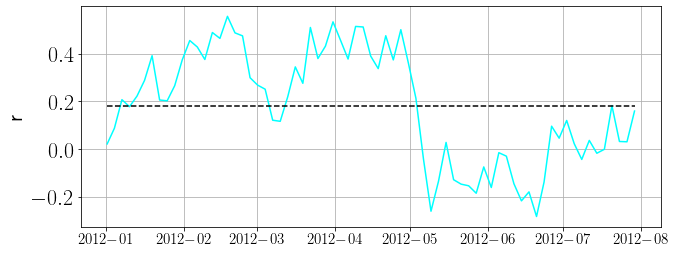

In [176]:
plt.figure(figsize=(10,4))
# plt.plot(tf.dayofyear,np.corrcoef())
plt.plot(timer[::tdec],alphaS_t_filtered,color='navy')
plt.plot(timer[::tdec],np.zeros(alphaS_t_filtered.shape)+np.nanmean(alphaS_t_filtered),'--',color='black')
# plt.xlabel('Days')
plt.ylabel(r'$\alpha_{S}$ [W m$^{-2}$]')
plt.xticks(fontsize=15)
plt.tight_layout()
plt.grid()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/alphaS(t)_(SaltXSH+LH)_scale{0}km.png'.format(scal_i))

plt.figure(figsize=(10,4))
# plt.plot(tf.dayofyear,np.corrcoef())
plt.plot(timer[::tdec],pearsonr_t_filtered,color='cyan')
plt.plot(timer[::tdec],np.zeros(pearsonr_t_filtered.shape)+np.nanmean(pearsonr_t_filtered),'--',color='black')
# plt.xlabel('Days')
plt.ylabel(r'r')
plt.xticks(fontsize=15)
plt.tight_layout()
plt.grid()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/pearson_r(t)_(SaltXSH+LH)_scale{0}km.png'.format(scal_i))

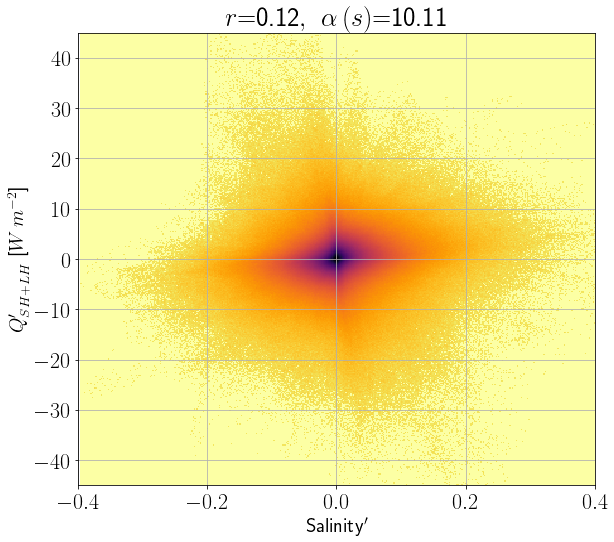

In [173]:
plt.figure(figsize=(9,8))
# plt.hist2d(np.ravel(rtf_f),np.ravel(rqf_f),bins=1000,density=True,norm=mpl.colors.LogNorm())
plt.hist2d(np.ravel(rsf_f),np.ravel(rqf_f),bins=500,density=True,norm=mcolors.PowerNorm(0.25),cmap='inferno_r')


plt.grid()
plt.xlabel(r'Salinity$^{\prime}$',fontsize=20,fontweight='bold')
plt.ylabel(r'$Q_{SH + LH}^{\prime}$ [$W\,m^{-2}$]',fontsize=20,fontweight='bold')
plt.title(r'$r$'+'={0:.2f}'.format(np.corrcoef(np.ravel(rsf_f),np.ravel(rqf_f))[0][1])+ r'$,\,\,\alpha\,(s)$={0:.2f}'.format(np.polyfit(np.ravel(rsf_f),np.ravel(rqf_f),deg=1)[0]))
# plt.colorbar()
plt.xlim(-0.4,0.4)
plt.ylim(-45,45)
plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/total_scatter_Saltx(LH+SH)_{0}km.png'.format(scal_i))



# $\alpha_{S} \times \lambda$

In [210]:
%%time
scales_number=[10,30,50,70,90,100]    
day_i=171

alphaS_f_scal=[]
pearsonr_f_scal=[]
alphaS_sm_scal=[]
pearsonr_sm_scal=[]
dec=2

for scal in scales_number:    
    
    grid_croco,scale_radius,scale_circ,scale_areasum=area_filter(lon=sf[:,::dec,::dec].nav_lon_rho,
                                  lat=sf[:,::dec,::dec].nav_lat_rho,
                                  filter_scale=scal,dim_x='x_rho',dim_y='y_rho')


    sf_sm=apply_area_filter(sf[day_i][::dec,::dec],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)


    qf_sm=apply_area_filter(qf[day_i][::dec,::dec],gs=grid_croco,
                            radius=scale_radius,circ=scale_circ,Asum=scale_areasum)

    r_sf_sm=sf_sm.data[~np.isnan(sf_sm.data)]
    r_qf_sm=qf_sm.data[~np.isnan(qf_sm.data)]


    r_sf_f=(sf[day_i][::dec,::dec]-sf_sm).data[~np.isnan(sf_sm.data)]
    r_qf_f=(qf[day_i][::dec,::dec]-qf_sm).data[~np.isnan(qf_sm.data)]
    
    alphaS_f_scal.append(np.polyfit(r_sf_f,r_qf_f,deg=1)[0])
    pearsonr_f_scal.append(np.corrcoef(r_sf_f,r_qf_f)[0][1])
    alphaS_sm_scal.append(np.polyfit(r_sf_sm,r_qf_sm,deg=1)[0])
    pearsonr_sm_scal.append(np.corrcoef(r_sf_sm,r_qf_sm)[0][1])






CPU times: user 2min 50s, sys: 3min 42s, total: 6min 33s
Wall time: 6min 33s


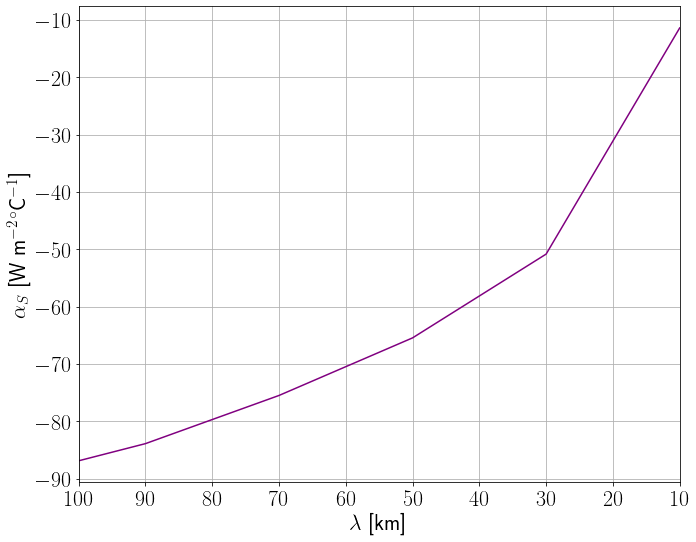

In [211]:
plt.figure(figsize=(10,8))
plt.plot(np.array(scales_number),alphaS_f_scal,color='purple')
plt.ylabel(r'$\alpha_{S}$ [W m$^{-2}$$^{\circ}$C$^{-1}$]')
plt.xlabel(r'$\lambda$ [km]')
plt.xlim(np.array(scales_number).max(),np.array(scales_number).min())
plt.grid()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_alphaS_x_lamdba_day.png'.format(day_i))

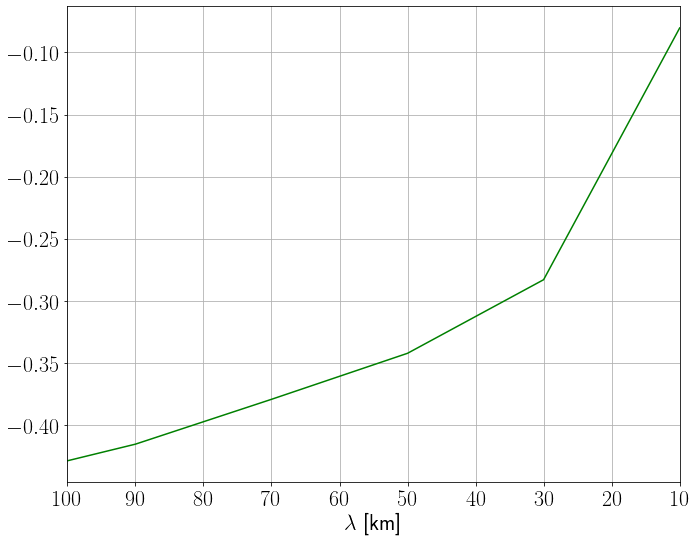

In [212]:
plt.figure(figsize=(10,8))
plt.plot(np.array(scales_number),pearsonr_f_scal,color='green')
# plt.ylabel(r'$\alpha$ [W m$^{-2}$$^{\circ}$C$^{-1}$]')
plt.xlabel(r'$\lambda$ [km]')
plt.xlim(np.array(scales_number).max(),np.array(scales_number).min())
plt.grid()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/coupling_coeff/day_{0}_correlation(SaltxLH+SH)_x_lamdba_day.png'.format(day_i))